# Pre-process single-cell methylome data with sincei

This tutorial uses a subset of data from the snmCAT-seq protocol presented in [Luo et. al (2022)](https://www.sciencedirect.com/science/article/pii/S2666979X22000271)

We have pre-processed the dataset to aggregate the methylation counts in 10-kb bins, which we provide on [figshare](https://figshare.com/articles/dataset/snmCAT-seq_testdata_package/26372467).

You can rename the downloaded and unzipped folder to **snmC2Tseq_eckerlab**

The the zip file contains a subfolder named **luo2022_snmCATseq_10kbinned.tgz**, which can be untared and the underlying files can be moved to another subfolder `snmC2Tseq_eckerlab/10k_bin/binned_10kb_all/`.


**NOTES**:
- "unmeth" does not correspond to a proper column, it is the total number of reads per bin. You can check this by observing that the ratio of meth/unmeth maxes out at 0.5.
- If the download command below fails, you may download the data directly from the figshare link above.

In [ ]:
%%bash
# Download and unzip the pre-processed snmCAT-seq 10kb binned data
wget 26372467.zip https://figshare.com/ndownloader/files/26372467
gunzip 26372467.zip
mv 26372467 snmC2Tseq_eckerlab
tar -xvzf luo2022_snmCATseq_10kbinned.tgz

In [1]:
import os, tqdm, math
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

data_type = 'HCGN'

## 1. 10k bin processing

We have pre-processed the data to create a 10k-binned dataset. Here we import the single-sample sets and aggregate them into one dataset.

### Filter by bin coverage
We use sequencing depth as a first filter to select the bins we will keep for later analysis.

In [3]:
def format_one_sample_depth(f, output_type='GCYN'):
    # output_type: GCYN or HCGN
    df = pd.read_csv(f, sep='\t').set_index('ctxt')
    df = df.loc[output_type].set_index('binID')
    df = df['unmeth']
    df = df.loc[[e for e in df.index if type(e) is str]]
    return ((output_type, f), df)

In [ ]:
bin_dir = 'snmC2Tseq_eckerlab/binned_10kb_all/'
bin_depth_df = Parallel(n_jobs=32, verbose=0)(
    delayed(format_one_sample_depth)(
        os.path.join(bin_dir, f),
        output_type=data_type
    ) for f in tqdm.tqdm(os.listdir(bin_dir))
)

bin_depth_df = pd.concat(dict(bin_depth_df), axis=1)
bin_depth_df = bin_depth_df.loc[
    [e for e in bin_depth_df.index if type(e) is str or not math.isnan(e)]
]

100%|███████████████████████████████████████████████████████████████████████████████| 2107/2107 [04:01<00:00,  8.73it/s]


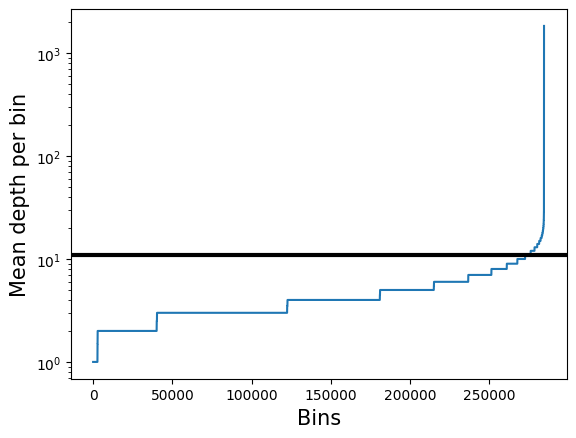

In [ ]:
bin_depth_ranking_df = bin_depth_df.median(axis=1).sort_values()
plt.plot(bin_depth_ranking_df.values)
plt.axhline(bin_depth_ranking_df.tail(10000).values[0], linewidth=3, color='black')
plt.ylabel('Mean depth per bin', fontsize=15)
plt.xlabel('Bins', fontsize=15)
plt.yscale('log')

relevant_bins = bin_depth_ranking_df.tail(10000).index
relevant_bins = np.array(relevant_bins).astype(str)
relevant_bins = relevant_bins[relevant_bins != 'nan']

np.savetxt(f"snmC2Tseq_eckerlab/top_bins_{data_type}.txt", relevant_bins.astype(str), fmt='%s')

In [ ]:
relevant_bins = np.loadtxt(f"snmC2Tseq_eckerlab/top_bins_{data_type}.txt", dtype=str)

### Import methylation ratio

In [ ]:
def format_one_sample_ratio(f, output_type='GCYN', relevant_bins=None):
    # output_type: GCYN or HCGN
    df = pd.read_csv(f, sep='\t').set_index('ctxt')
    df = df.loc[output_type].set_index('binID')
    
    # Keep relevant bins
    if relevant_bins is not None:
        df = df.loc[np.intersect1d(df.index.astype(str), relevant_bins)]
    
    # Recompute ratio (not well computed in the tool, leading to a cap at 0.5).
    df['ratio'] = df['meth'] / df['unmeth']
    df = df['ratio']
    
    df = df.loc[[e for e in df.index if type(e) is str]]
    return ((output_type, f), df)

In [ ]:
bin_dir = 'snmC2Tseq_eckerlab/binned_10kb_all'
formatted_df = Parallel(n_jobs=32, verbose=0)(
    delayed(format_one_sample_ratio)(
        os.path.join(bin_dir, f), 
        relevant_bins=relevant_bins,
        output_type=data_type
    )
    for f in tqdm.tqdm(os.listdir(bin_dir))
)

formatted_df = pd.concat(dict(formatted_df), axis=1)
formatted_df = formatted_df.loc[
    [e for e in formatted_df.index if type(e) is str or not math.isnan(e)]
]

100%|███████████████████████████████████████████████████████████████████████████████| 2107/2107 [03:19<00:00, 10.54it/s]


## 2. Restrict ratio to deeply sequenced bins
Here we filter the bins for which we lack data in many cells.

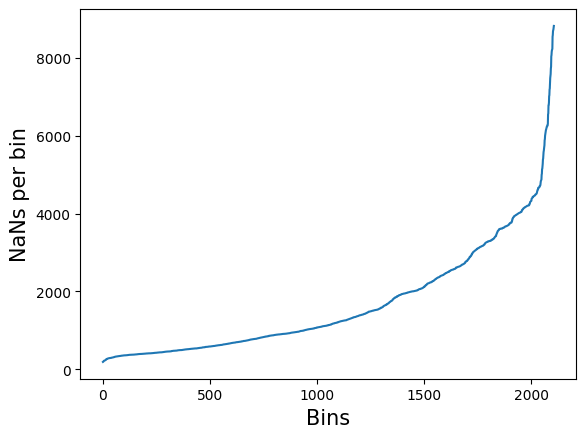

In [ ]:
plt.plot(formatted_df.isna().sum(axis=0).sort_values().values)
plt.ylabel('NaNs per bin', fontsize=15)
plt.xlabel('Bins', fontsize=15)

filtered_formatted_df = formatted_df.loc[:, formatted_df.isna().sum(axis=0) < 4000]

Below we impute the values for cells lacking data for the remaining bins after filtering. We impute
the missing values as the mean of the methylation ratio of every cell with data for that same bin.

In [ ]:
# Mean imputation per row
filtered_formatted_df = filtered_formatted_df.fillna(filtered_formatted_df.mean(axis=0), axis=0)
filtered_formatted_df = filtered_formatted_df.T

In [ ]:
filtered_formatted_df.to_csv(f"snmC2Tseq_eckerlab/processed_data_{data_type}.csv.gz", compression='gzip')